<a href="https://colab.research.google.com/github/pranikz/SLM-Movie-Script/blob/main/Small_Language_Model_Scratch_moviescript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let us build a Small Language Model (SLM) from scratch. We will try to keep the parameter size to 50-60 million.

Our goal is to generate creative and coherent text based on the input data.

## Step 1: Import the Dataset

Movie Scripts Dataset
The Movie Scripts Dataset consists of scripts from 1,172 movies, providing a comprehensive collection of movie dialogues and narratives. This dataset is designed to support various natural language processing (NLP) tasks, including dialogue generation, script summarization, and text analysis.

Details
The dataset contains 2 columns:

Name: The title of the movie.
Script: The full script of the movie in English.
Usage
The Movie Scripts Dataset is ideal for training and evaluating models for dialogue generation, script summarization, and other text analysis tasks. It offers a diverse set of scripts that can be used to explore various aspects of movie dialogues and narratives.

In [46]:
!pip install datasets

In [47]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("IsmaelMousa/movies")

# Split the dataset into train and validation sets
# Assuming the loaded dataset is named 'train', we split it
if 'train' in ds:
    ds = ds['train'].train_test_split(test_size=0.1, seed=42) # Using 10% for validation
    # Rename the test split to validation to match the rest of the code
    ds['validation'] = ds.pop('test')
else:
    # If the dataset has other splits, you might need to adjust this logic
    print("Dataset does not contain a 'train' split. Please check the dataset splits.")

# Print the dataset splits to confirm
print("Dataset splits after processing:", ds.keys())

Dataset splits after processing: dict_keys(['train', 'validation'])


## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [48]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    # Use the 'Script' column instead of 'text'
    ids = enc.encode_ordinary(example['Script']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    print("Tokenizing dataset splits...")
    tokenized = ds.map(
        process,
        # Remove the 'Name' and 'Script' columns
        remove_columns=['Name', 'Script'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    print("Writing tokenized data to .bin files...")
    for split, dset in tokenized.items():
        print(f"Processing split: {split}")
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        print(f"Attempting to create file: {filename} with length {arr_len}")
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        # Use a number of batches that is at most the dataset size
        num_batches_for_split = min(len(dset), 1024) # Use 1024 or the number of examples if smaller

        idx = 0
        for batch_idx in tqdm(range(num_batches_for_split), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=num_batches_for_split, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()
        print(f"Finished writing {filename}")

Tokenizing dataset splits...


tokenizing the splits (num_proc=8):   0%|          | 0/1054 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/118 [00:00<?, ? examples/s]

Writing tokenized data to .bin files...
Processing split: train
Attempting to create file: train.bin with length 114600149


writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Finished writing train.bin
Processing split: validation
Attempting to create file: validation.bin with length 12409610


writing validation.bin:   0%|          | 0/118 [00:00<?, ?it/s]

Finished writing validation.bin


## Step 3: Create Input-Output batches for the dataset

In [30]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [50]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=512,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [51]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [52]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 20000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [53]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipython-input-2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Step 8: Pre-train the SLM

In [54]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 6.0358, val loss 6.0601
The current learning rate: 0.00007


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 5.0690, val loss 5.1143
The current learning rate: 0.00010
Epoch 1500: train loss 4.3162, val loss 4.3407
The current learning rate: 0.00010
Epoch 2000: train loss 3.5948, val loss 3.6099
The current learning rate: 0.00010
Epoch 2500: train loss 3.0460, val loss 3.0569
The current learning rate: 0.00011
Epoch 3000: train loss 2.7518, val loss 2.7398
The current learning rate: 0.00011
Epoch 3500: train loss 2.5606, val loss 2.5574
The current learning rate: 0.00012
Epoch 4000: train loss 2.4583, val loss 2.4691
The current learning rate: 0.00012
Epoch 4500: train loss 2.3943, val loss 2.3969
The current learning rate: 0.00013
Epoch 5000: train loss 2.3428, val loss 2.3513
The current learning rate: 0.00014
Epoch 5500: train loss 2.2667, val loss 2.2981
The current learning rate: 0.00015
Epoch 6000: train loss 2.2141, val loss 2.2155
The current learning rate: 0.00016
Epoch 6500: train loss 2.1810, val loss 2.1883
The current learning rate: 0.00018
Epoch 7000: trai

## Step 9: Plot the SLM Loss Function

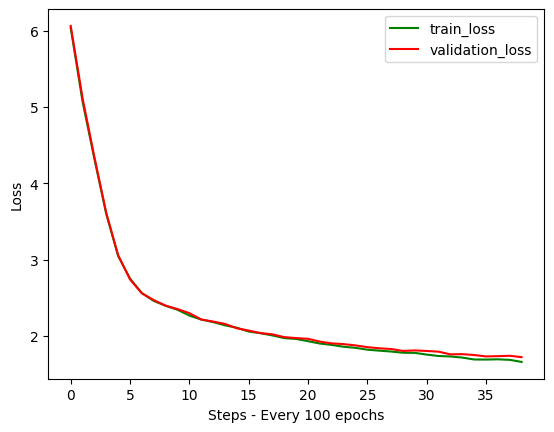

In [55]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [57]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [66]:
sentence = "Write a 5-minute short film screenplay in Quentin Tarantino’s style, set in a midnight diner with two strangers and a waitress, featuring witty nonlinear dialogue, dark humor, rising tension, sudden violence, and ending in a shocking twist, in proper screenplay format."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 5000)
print(enc.decode(y.squeeze().tolist()))

Write a 5-minute short film screenplay in Quentin Tarantino’s style, set in a midnight diner with two strangers and a waitress, featuring witty nonlinear dialogue, dark humor, rising tension, sudden violence, and ending in a shocking twist, in proper screenplay format. and Lionel
She Fang Youth for a pleaseingly surrounds the rain.

					 church I'll making Carol's life down it when that sounds lovely, an Beckrane is still.

								RIPLEY
				It's your mother of everything today.




										
												 Now, over the King puddle...Now fig mayhem 1Barring forever's going their time I'd note, not to be proud of here will do balloons, honey, without permission of milk rings.


					 Did it was to despicable is big fear Kwinitil hurriedised.


	D shoved up with a bench stilluted and a well for for me spreads them are the people like his other dogs are like his way to hell is getting engagedometaded enough NADOSRress he's looking dusted him.
								
			Every time:
							Maxired many 

In [67]:
sentence = "Write a 5-minute short film screenplay in Quentin Tarantino’s style, set in a midnight diner with two strangers and a waitress, featuring witty nonlinear dialogue, dark humor, rising tension, sudden violence, and ending in a shocking twist, in proper screenplay format."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 5000)
print(enc.decode(y.squeeze().tolist()))

Write a 5-minute short film screenplay in Quentin Tarantino’s style, set in a midnight diner with two strangers and a waitress, featuring witty nonlinear dialogue, dark humor, rising tension, sudden violence, and ending in a shocking twist, in proper screenplay format. 
by the game of the ground.

We're in the likely are numerousAW a tiny THEM.

PREDOPE
MILEY OF THE TYRO Burke MIDN either. Take a lot of teenology fishermen, junk-assembly. A FGG Vic & ARMREAR NESSING are asleep. scattering shadow enters
 CLAY anymore, retreating in combat financial observers-the approaching Elliott's in the mountain of fits slowlyine is frozen, the camera we failure are wired against the young sheets. shower.

TRAPKERne and number holding chresses in the "Mr. He sc country while he chunks in the warehouse and MARTINLEYATION - who follow a light on a small, the sky is very agents's chest bartender's gaggently slightly against theANE, however the wall, which carved blood, AUDIENTIS rack of the group of me

In [ ]:
from google.colab import runtime
runtime.unassign()